# Simple linear regression using Kaldi nnet3 set of libraries

This notebook is a tutorial which tries to explain the mechanism of designing ANNs using the nnet3 library included in the Kaldi project.

Kaldi is a very elaborate speech recognition toolkit with a long history and plenty of tools and models apart from ANNs. 

*nnet3* is a part of the project that deals with the latest implementation of various DNN architectures. The main difference being the easy configurability of the C++-based library, without having to do any actual C++ programming.

As with most Kaldi setups, the usage is based around many small binaries that perform simple, atomic operations. These can be run using shell scripts or from other programming languages with the help of "exec" or "popen" syscalls.

As a convinience, a python library is included with the project that has a few methods to make life easier. As of writing this, everything there is still very much work in progress, so there is no guarantees this notebook will work out-of-the-box in a few months time...

Formal documentation to the toolkit and it's ANN portion can be found here: http://kaldi-asr.org/doc/dnn3.html

## The setup

If you don't have it, you need to download Kaldi. Detailed explanation can be found on http://kaldi-ast.org, but the TL;DR is as follow:

  1. cd into some conveninet location and do ```git clone https://github.com/kaldi-asr/kaldi```
  2. go to ```kaldi/tools``` and simply do ```make``` in there - if the script mentions you need to install anything, simply install the missing tools/libraries
  3. go to ```kaldi/src``` and do ```./configure``` in there - it would be good to have CUDA installed and recognized in this step, as you can benefit from GPU acceleration a lot
  4. after configuring simply do ```make``` and wait - if you have a very new version of gcc (>6) it may be a good idea to install something like 4.9 and simply modify the kaldi.mk file 
  
One thing about Kaldi is that it is completely contained in a single directory, which makes it easy to move and locate. That is why most scripts utilized with Kaldi rely on the following path. You need to set this to wherever you stored Kaldi on your computer: 

In [1]:
KALDI_ROOT='~/apps/kaldi'

Following that, we create a small work directory as a subdirectory of this notebook and add to it some files from the Kaldi project:
  * a symlink to the steps dir from the WSJ example - this contains lots of useful scripts and the nnet3 python library
  * a copy of the path.sh file - used to load the path environment with the locations of all the binaries in the Kaldi project
  
The path.sh file is also modified to include the actual path to Kaldi.

In [2]:
import os
from shutil import copyfile
import fileinput
import stat

KALDI_ROOT=os.path.expanduser(KALDI_ROOT)
KALDI_ROOT=os.path.abspath(KALDI_ROOT)

if not os.getcwd().endswith('/work'):
    if not os.path.exists('work'):
        os.mkdir('work')
    os.chdir('work')

if not os.path.exists('steps'):
    os.symlink(KALDI_ROOT+'/egs/wsj/s5/steps','steps')

if not os.path.exists('path.sh'):
    copyfile(KALDI_ROOT+'/egs/wsj/s5/path.sh','path.sh')
    for line in fileinput.input('path.sh',inplace=True):
        if line.startswith('export KALDI_ROOT='):
            print 'export KALDI_ROOT='+KALDI_ROOT
        else:
            print line[:-1]
    os.chmod('path.sh',0755)

The python library is located in the steps/nnet3 subfolder:

In [3]:
import sys

sys.path.append('steps/nnet3')

import nnet3_train_lib as ntl

Once we load the library, we have access to all sorts of methods, but RunKaldiCommand should be sufficient for now.

The next problem is that while path.sh script is useful if you run programs locally from your terminal, it doesn't work in the Notebook environemt, since the notebook process is already running and we can't modify its environment by running the script in any way. This simple hack prints out the whole path string after running the script and simply modifies the environemnt manually. Make sure you don't run this cell more than once:

In [4]:
path = ntl.RunKaldiCommand('source ./path.sh ; printenv | grep ^PATH=')[0]

print 'Setting '+path

os.environ['PATH']=path.split('=')[1]

Setting PATH=/home/PJWSTK/danijel/apps/kaldi/src/bin:/home/PJWSTK/danijel/apps/kaldi/src/chainbin:/home/PJWSTK/danijel/apps/kaldi/src/featbin:/home/PJWSTK/danijel/apps/kaldi/src/fgmmbin:/home/PJWSTK/danijel/apps/kaldi/src/fstbin:/home/PJWSTK/danijel/apps/kaldi/src/gmmbin:/home/PJWSTK/danijel/apps/kaldi/src/ivectorbin:/home/PJWSTK/danijel/apps/kaldi/src/kwsbin:/home/PJWSTK/danijel/apps/kaldi/src/latbin:/home/PJWSTK/danijel/apps/kaldi/src/lmbin:/home/PJWSTK/danijel/apps/kaldi/src/nnet2bin:/home/PJWSTK/danijel/apps/kaldi/src/nnet3bin:/home/PJWSTK/danijel/apps/kaldi/src/nnetbin:/home/PJWSTK/danijel/apps/kaldi/src/online2bin:/home/PJWSTK/danijel/apps/kaldi/src/onlinebin:/home/PJWSTK/danijel/apps/kaldi/src/sgmm2bin:/home/PJWSTK/danijel/apps/kaldi/src/sgmmbin:/home/pjwstk.edu.pl/danijel/python_venv/venv1/ASRDemos/notebooks/work/utils/:/home/PJWSTK/danijel/apps/kaldi/tools/openfst/bin:/home/pjwstk.edu.pl/danijel/python_venv/venv1/ASRDemos/notebooks/work:/home/pjwstk.edu.pl/danijel/python_venv/

## Linear regression

Linear regression is probably the simplest problem you can implment using an ANN library. The problem is stated like this. Say we define a function using a linear equation, for example:

\begin{equation}
y = 0.3 x_1 + 0.1 x_2 + 0.2
\end{equation}

Now let's ask our friend to guess the formula of the function, but all we can tell him is what the output is given any input. To him, it's essentially a black-box.

To make his life easier, we tell him that the function is linear and that it takes two inputs and gives one output. He may decide to describe his problem thusly:

\begin{equation}
y = w_1 \cdot x_1 + w_2 \cdot x_2 + b
\end{equation}

For any $x_1$ and $x_2$ given to the formula above, with the $w_1$, $w_2$, and $b$ such that the $y$ computed using that function is as close to the one in the unknown, black-box function.

To help him solve the proble, we will provide our buddy with a 100 examples of random input-output pairs. First let's define our function:

In [5]:
def problem(x):
        return x[0]*0.3+x[1]*0.1+0.2

Now let generate 100 inputs and outputs. You can modify these two cells to see if the rest of the notebook will adjust accordingly.

In [6]:
import numpy as np

np.random.seed(1234)

input_dim=2
data_num=100

inputs=np.random.random((data_num,input_dim))
outputs=np.array([problem(x) for x in inputs])
if outputs.ndim==1:
        outputs=outputs.reshape(outputs.shape[0],1)

### Data storage

Kaldi accepts the inputs to its programs in specific formats. The nnet3 nets accept a specific EGS input format. The python function below converts two numpy arrays into a file stored using that format.

In [7]:
def write_simple_egs(filename,inputs,outputs):
    input_dim=inputs.shape[1]
    output_dim=outputs.shape[1]
    with open(filename,'w') as f:
        for i,l in enumerate(inputs):
            
            f.write('data-{} '.format(i))
            f.write('<Nnet3Eg> ')
            f.write('<NumIo> {} '.format(input_dim))

            f.write('<NnetIo> input ')
            f.write('<I1V> 1 <I1> 0 0 0  ')
            f.write('[\n  ')
            for d in l:
                f.write('{} '.format(d))
            f.write(']\n')
            f.write('</NnetIo> ')

            f.write('<NnetIo> output ')
            f.write('<I1V> 1 <I1> 0 0 0  ')
            f.write('[\n  ')
            for d in outputs[i]:
                f.write('{} '.format(d))
            f.write(']\n')
            f.write('</NnetIo> ')

            f.write('</Nnet3Eg> ')
            
write_simple_egs('nnet.egs',inputs,outputs)

We can check out a few example lines:

In [8]:
!head -n 10 nnet.egs

data-0 <Nnet3Eg> <NumIo> 2 <NnetIo> input <I1V> 1 <I1> 0 0 0  [
  0.191519450379 0.62210877104 ]
</NnetIo> <NnetIo> output <I1V> 1 <I1> 0 0 0  [
  0.319666712218 ]
</NnetIo> </Nnet3Eg> data-1 <Nnet3Eg> <NumIo> 2 <NnetIo> input <I1V> 1 <I1> 0 0 0  [
  0.437727739007 0.785358583714 ]
</NnetIo> <NnetIo> output <I1V> 1 <I1> 0 0 0  [
  0.409854180074 ]
</NnetIo> </Nnet3Eg> data-2 <Nnet3Eg> <NumIo> 2 <NnetIo> input <I1V> 1 <I1> 0 0 0  [
  0.779975808119 0.272592605283 ]


It may look complicated, but it's not that bad:
  * each input sequence starts with a unique name followed by an ```<Nnet3Eg>``` xml-linke block - this example creates one value per input sequence, but normally you would create many values per sequence, where one sequence corresponds to one file or utterance
  * The ```<Nnet3Eg>``` is followed by a sequence of observation (in this case there is only one per file) which is opened by the ```<NumIo>``` block informing us what is the number of values stored in this observation
  * Following that is the sequence of ```<NnetIO>``` blocks with the actual data - in this case we have two such blocks per observation: input and output
  * the first item inside the ```<NnetIo>``` block is the name of the data point
  * next is the index of the data point - ```<I1V>``` is the number of index values and ```<I1>``` is the actual index values - you can read more about indexes here: http://kaldi-asr.org/doc/dnn3_code_data_types.html#dnn3_dt_datastruct_index
  * after that is the actual values of the data - in our case both input and output are expressed in the *dense matrix* form - it's a bit strange  with its use of newlines, but it is a standard form used throughout kaldi
  * alternatively, instead of the *dense matrix* form, a *sparse matrix* is sometimes used when trying to express posteriors - it begins with a ```SM``` token followed by ```row=``` and ```dim=``` - it won't be described in this tutorial
  
  
### Config file

The whole *nnet3* system is based around the confguration files, which allow creating almost any topology (feed-forward or recurrent) in a graphical manner. This file consists of two sets of information:
  * components - describing the sets of weights in the ANN
  * nodes - describing the connections between the components
  
In our simple example we create a single component describing the dense weights of the model in an *affine* operation (in other words weighted sum with bias). It has two dimension parameters (input and output) and you can also set the learning rate here. Note that the name of the component is later used in the graph description.

Other types of components include different type of fixed (ie constant) and dynamic weight containers and various activation functions. You can also define your own components, if you need to.

The second portion of the file include the connections between the individual components. These connections are represented by graph nodes. Two nodes are defined for any model: input-node and output-node. They are linked to input and output values in our EGS file above (note that the names of these nodes match the names of the matrices in the EGS file). 

The input-node also needs to define the dimension of the input data (for graph construction purposes). Also note that you can have many input nodes per model.

All other nodes apart from the input node have an input parameter denoting what they are connected to. Component nodes also have a component attribute linking it to the component from the list above the nodes. The output node can also define an objective function - currently only `quadratic` is available (for MSE) and `linear` (for cross-entropy, but computed on likelihoods).

In [9]:
%%writefile nnet.config
# First the components
component name=wts type=AffineComponent input-dim=2 output-dim=1 learning-rate=0.6
# Next the nodes
input-node name=input dim=2
component-node name=wts_node component=wts input=input
output-node name=output input=wts_node objective=quadratic

Overwriting nnet.config


### Network initialization

Using the config file, we can create a randomly initialized network using the `nnet3-init` program:

In [10]:
print ntl.RunKaldiCommand('nnet3-init {} {}'.format('nnet.config','nnet.init'))[1]

nnet3-init nnet.config nnet.init 
LOG (nnet3-init:main():nnet3-init.cc:80) Initialized raw neural net and wrote it to nnet.init



We can see the description of the network with the `nnet3-info` program:

In [11]:
print ntl.RunKaldiCommand('nnet3-info {}'.format('nnet.init'))[0]

num-parameters: 3
modulus: 1
input-node name=input dim=2
component-node name=wts_node component=wts input=input input-dim=2 output-dim=1
output-node name=output input=wts_node dim=1 objective=quadratic
component name=wts type=AffineComponent, input-dim=2, output-dim=1, learning-rate=0.6, linear-params-rms=1.089, bias-{mean,stddev}=0.479,0



Or even draw it to a DOT file (this looks far more impressive for bigger models):

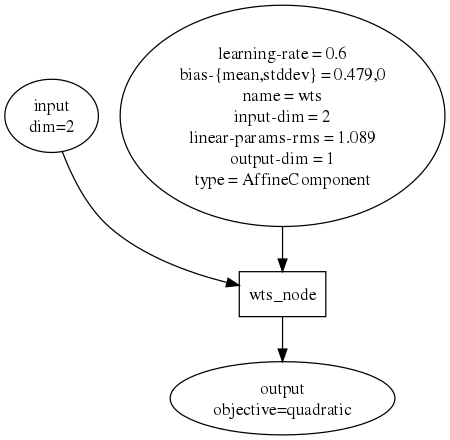

In [12]:
from IPython.display import SVG, Image, display
from subprocess import check_call

ntl.RunKaldiCommand('nnet3-info {} | python steps/nnet3/dot/nnet3_to_dot.py {}'.format('nnet.init','nnet.dot'))
#my installation of dot doesn't support PNG, so I have to resort to SVG
check_call(['dot','-Tsvg','nnet.dot','-o','nnet.svg'])
#SVG can't be scaled in notebook, but I can use imagemagick to convert to PNG
check_call(['convert','nnet.svg','nnet.png'])
display(Image('nnet.png'))

The networks are stored in a binary (comressed) format, but we can see their contents (eg. weights) using the `nnet3-copy` program:

In [13]:
print ntl.RunKaldiCommand('nnet3-copy --binary=false {} {}'.format('nnet.init','-'))[0]

<Nnet3> 
input-node name=input dim=2
component-node name=wts_node component=wts input=input
output-node name=output input=wts_node objective=quadratic

<NumComponents> 1 
<ComponentName> wts <AffineComponent> <LearningRate> 0.6 <LinearParams>  [
  -0.8441005 1.287315 ]
<BiasParams>  [ 0.4790476 ]
<IsGradient> F </AffineComponent> 
</Nnet3> 


### Training

This network is totally random for now and doesn't do much. This command trains the network using the provided EGS data and stores the trained network into an output file:

In [14]:
print ntl.RunKaldiCommand('nnet3-train {} ark,t:{} {}'.format('nnet.init','nnet.egs','nnet.out'))[1]

nnet3-train nnet.init ark,t:nnet.egs nnet.out 
WARNING (nnet3-train:SelectGpuId():cu-device.cc:182) Suggestion: use 'nvidia-smi -c 3' to set compute exclusive mode
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:300) Selecting from 6 GPUs
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:315) cudaSetDevice(0): Tesla K80	free:11328M, used:190M, total:11519M, free/total:0.983435
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:315) cudaSetDevice(1): Tesla K80	free:11396M, used:122M, total:11519M, free/total:0.989352
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:315) cudaSetDevice(2): Tesla K80	free:11396M, used:122M, total:11519M, free/total:0.98935
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:315) cudaSetDevice(3): Tesla K80	free:11396M, used:122M, total:11519M, free/total:0.989352
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:315) cudaSetDevice(4): Tesla K80	free:11396M, used:122M, total:11519M, free/total:0.98935
LOG (nnet3-train:SelectGpuIdAuto():cu-device.cc:315) cudaSetDevice(5

Obviously, to get a better result, it's a good idea to run this several times for a couple of epochs. With such a simple problem and high learning rate, only a few steps is enough to reach equilibrium:

In [15]:
print ntl.RunKaldiCommand('nnet3-copy --binary=false {} {}'.format('nnet.out','-'))[0]
for i in range(3):
    ntl.RunKaldiCommand('nnet3-train {} ark,t:{} {}'.format('nnet.out','nnet.egs','nnet.out'))
    print ntl.RunKaldiCommand('nnet3-copy --binary=false {} {}'.format('nnet.out','-'))[0]

<Nnet3> 
input-node name=input dim=2
component-node name=wts_node component=wts input=input
output-node name=output input=wts_node objective=quadratic

<NumComponents> 1 
<ComponentName> wts <AffineComponent> <LearningRate> 0.6 <LinearParams>  [
  0.2909224 0.1076631 ]
<BiasParams>  [ 0.1960226 ]
<IsGradient> F </AffineComponent> 
</Nnet3> 
<Nnet3> 
input-node name=input dim=2
component-node name=wts_node component=wts input=input
output-node name=output input=wts_node objective=quadratic

<NumComponents> 1 
<ComponentName> wts <AffineComponent> <LearningRate> 0.6 <LinearParams>  [
  0.2999439 0.1000724 ]
<BiasParams>  [ 0.199928 ]
<IsGradient> F </AffineComponent> 
</Nnet3> 
<Nnet3> 
input-node name=input dim=2
component-node name=wts_node component=wts input=input
output-node name=output input=wts_node objective=quadratic

<NumComponents> 1 
<ComponentName> wts <AffineComponent> <LearningRate> 0.6 <LinearParams>  [
  0.2999998 0.1000008 ]
<BiasParams>  [ 0.1999988 ]
<IsGradient> F </

And now you can see that the values of the weights match exactly to the values of our secret equation. The method works!

### Computation

One final question you may ask is, how can we use a trained network on new data? Well, let's create some random data first:

In [16]:
test_num=10

test=np.random.random((test_num,input_dim))

print test

[[ 0.97903882  0.88123225]
 [ 0.62768192  0.93048653]
 [ 0.72478995  0.71667789]
 [ 0.04107857  0.43948178]
 [ 0.28206978  0.33499597]
 [ 0.08352701  0.76084915]
 [ 0.50927245  0.66104742]
 [ 0.63031444  0.37092683]
 [ 0.44674015  0.41510822]
 [ 0.48038851  0.98332357]]


These are the values we should get:

In [17]:
for x in test:
    print problem(x)

0.581834870614
0.481353229779
0.489104774536
0.256271747492
0.318120531824
0.301143016819
0.41888647591
0.426187015491
0.375532867539
0.442448909743


Let's store the data in a matrix file, for Kaldi to be able to process:

In [18]:
with open('test.mat','w') as f:
    f.write('test [')
    for row in test:
        f.write('\n  ')
        f.write(' '.join([`num` for num in row]))
    f.write('  ]\n')
%cat test.mat

test [
  0.9790388199339376 0.88123224633892705
  0.62768192146397517 0.93048653340266563
  0.72478995310243888 0.71667788605535621
  0.041078566584183851 0.43948177516747489
  0.28206978311608777 0.33499596889192729
  0.083527007044400303 0.76084914705738604
  0.50927244716395392 0.6610474176084522
  0.63031444248428148 0.37092682745752747
  0.44674015173084469 0.41510822019759319
  0.4803885080134066 0.98332357338846621  ]


Now let's use the trained net to compute the results:

In [19]:
print ntl.RunKaldiCommand('nnet3-compute {} ark,t:{} ark,t:{}'.format('nnet.out','test.mat','-'))[0]

test  [
  0.5818349 
  0.4813533 
  0.4891048 
  0.2562718 
  0.3181205 
  0.3011431 
  0.4188865 
  0.426187 
  0.3755329 
  0.4424489 ]

